In [77]:
import sys
base_dir = "D:/Thesis/Cobra/cobra/"
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import os
import pandas as pd
from utilities import utils, stats
from access_sif_data import load_data_tools as ld
import importlib
importlib.reload(utils)
from stats_tools import vis as svis
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
# Changes resolution and size of the figs
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')

# Check DateTime

## Load df and convert string to date and time

In [67]:
table_dir = join(base_dir, 'data','tables')
df = utils.load_scan_csv(join(table_dir, 'neg_pos.csv'))

ipykernel_launcher:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


ipykernel_launcher:2: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.


## Search for dates in Series Description

In [5]:
mask_missing_dates = df.InstanceCreationDate.isnull()
df_missing_date = df[mask_missing_dates]
print(len(df_missing_date), f'volumes out of {len(df)} have no date given')
print(f'{len(df)-len(df_missing_date)} volumes have a date')

54325 volumes out of 328489 have no date given
274164 volumes have a date


In [6]:
print(len(df_missing_date[stats.check_tags(df_missing_date, ['\d\d-'])].SeriesDescription))
print(len(df_missing_date[stats.check_tags(df_missing_date, ['\d\d:\dd'])].SeriesDescription))

0
0


No volumes for which the series description matches the pattern of a date or time

## Check if scans from same study can have different dates

In [88]:
df_dir_miss = df_dir[df_dir.SeriesInstanceUID.isin(df_missing_date.SeriesInstanceUID)]
df_dir_miss.Directory = df_dir_miss.Directory.map(lambda x: 'Y:\\'+x)
dir_dic = dict(df_dir_miss.values)

D:\Programme\Anaconda\envs\cobra\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
dir_list = list(dir_dic.values())
for dir_ in dir_list[200:201]:
    dir_ = dir_list[0]
    for slice in range(len(os.listdir(dir_))):
        date = ld.get_scan_date(dir_,  slice=slice)
        if date is not None:
            with open(join(base_dir, 'date_log.txt'), 'w') as f:
                f.write(f'{dir_}, {slice}, {date}\n')

### ->It seems that either all the scans have date given or none

## Plot difference in days distribution for each study

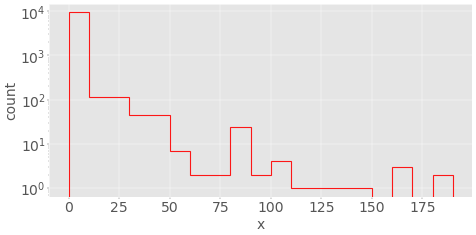

In [26]:
study_date_count = df.dropna(subset=['InstanceCreationDate']).groupby('StudyInstanceUID')['InstanceCreationDate'].nunique()
mask_diff_days = study_date_count[study_date_count>1]
df_different_dates = df[df.StudyInstanceUID.isin(mask_diff_days.index)]
df_different_dates = df_different_dates.dropna(subset=['InstanceCreationDate'])
gb_sid = df_different_dates.groupby('StudyInstanceUID')
first_day = gb_sid['InstanceCreationDate'].min()

differences = []
for index, row in df_different_dates.iterrows():
    differences.append((row['InstanceCreationDate'] - first_day[row['StudyInstanceUID']]).days)
differences = np.array(differences)

_ = svis.hist(differences, np.arange(0,200,10), kwargs={'ylogscale':True})

## -> because of the date differences within a study folder, we cannot replace missing values by the other dates in the study